<a href="https://colab.research.google.com/github/root-epifit/HPC_Sber_2025/blob/main/%D0%94%D0%B73_in_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 * Скачать и приготовить датасет Московского или
 Лондонского метро для решения стандартной задачи
 Pagerank. Вывести топ-5 станций подземки по такому
 ранжированию. (50 %)

 * Применить метод Simrank к графу Московской подземки
 (30 %)

 * Сгенерировать случайные разреженные графы и сравнить
 производительность реализаций Pagerank с CSR-форматом
 и без него. (20 %

## Импорты

In [175]:
!pip install kaggle
!pip install fast-pagerank

In [21]:
import kagglehub
from google.colab import files

import pandas as pd
import networkx as nx
import math

import matplotlib.pyplot as plt

import numpy as np
from scipy.sparse import random as sparse_random
from scipy.sparse import csr_matrix

import fast_pagerank

# Подготовка датасета

### Загрузка датасета

In [3]:
# загружаю свой kaggle-токен (нужен чтобы стянуть датасет)
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# проверка, что API работает
#! kaggle datasets list

# Загружаем датасет Moscow Metro
# Download latest version
path = kagglehub.dataset_download("samoilovmikhail/moscow-metro-stations")
print("Path to dataset files:", path)

!cp $path/* .
!ls -la *.csv

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Path to dataset files: /kaggle/input/moscow-metro-stations
-rw-r--r-- 1 root root  1449 Aug 23 14:54 metro_lines.csv
-rw-r--r-- 1 root root 34560 Aug 23 14:54 metro_stations.csv


### Изучение датасета

In [4]:
ms = pd.read_csv("./metro_stations.csv")
ml = pd.read_csv("./metro_lines.csv")

In [5]:
ml.head(2)

,Line,English_name,Russian_name,Stations,Color,First_Opened,Latest_extension,Length,Avg_Dist
0,1,Sokolnicheskaya,Сокольническая,27,#EF161E,1935,2024,43.4,1.61
1,2,Zamoskvoretskaya,Замоскворецкая,24,#2DBE2C,1938,2018,42.8,1.86


In [6]:
ms[ms['Station_index'].isin([6,92,93])].head(10)

,Station_index,English_name,Line,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Lat,Lon,Station_Type
5,6,Komsomolskaya,1,Комсомольская,-8.0,5 7,93,1935-05-15,55.7753,37.6561,column triple-span
91,92,Kurskaya,5,Курская,-40.0,91 93,206 66,1950-01-01,55.7570,37.6595,column triple-vault
92,93,Komsomolskaya,5,Комсомольская,-37.0,92 94,6,1952-01-30,55.7748,37.6549,column triple-vault


In [38]:
# Итого:

# ml.Line - код линии
# ml.Russian_name - название линии

# ms.Line - код линии -> ml.Line
# ms.Russian_name - название станции
# ms.Station_index - код станции
# ms.Line_Neighbours - коды предыдущей и следующей станции (на линии)
# ms.Transfers - коды станций, на которые есть пересадки с данной станции

## Подготовка графа

In [7]:
G = nx.Graph()

stations = []
edges = []
idx2name = {}

df = ms[['Station_index', 'Russian_name', 'Line', 'Line_Neighbors', 'Transfers']]

for idx, row in df.iterrows():
    station = row['Station_index']
    name    = row['Russian_name'].lstrip().rstrip()
    line    = row['Line']
    idx2name[station]=name
    edge = [(station, int(e)) for e in row['Line_Neighbors'].replace("\xa0",",").replace(" ",",").split(",")]
    # str(...) для преобразования NaN (имеет тип float) в 'nan'
    transfer = [(station,int(e)) if e != 'nan' else (0,0) for e in str(row['Transfers']).replace("\xa0",",").replace(" ",",").split(",")]

    stations.append((station, {"line":line}) )
    edges = edges + edge + transfer

# убираем мусорные (0,0)
edges = [e for e in filter(lambda x: x != (0,0), edges)]

# заменяем коды станций на названия + код
stations = [(idx2name[i]+','+str(i), o) for (i,o) in stations]
edges    = [(idx2name[l]+','+str(l), idx2name[r]+','+str(r)) for (l,r) in edges]

G.add_nodes_from(stations)
G.add_edges_from(edges)


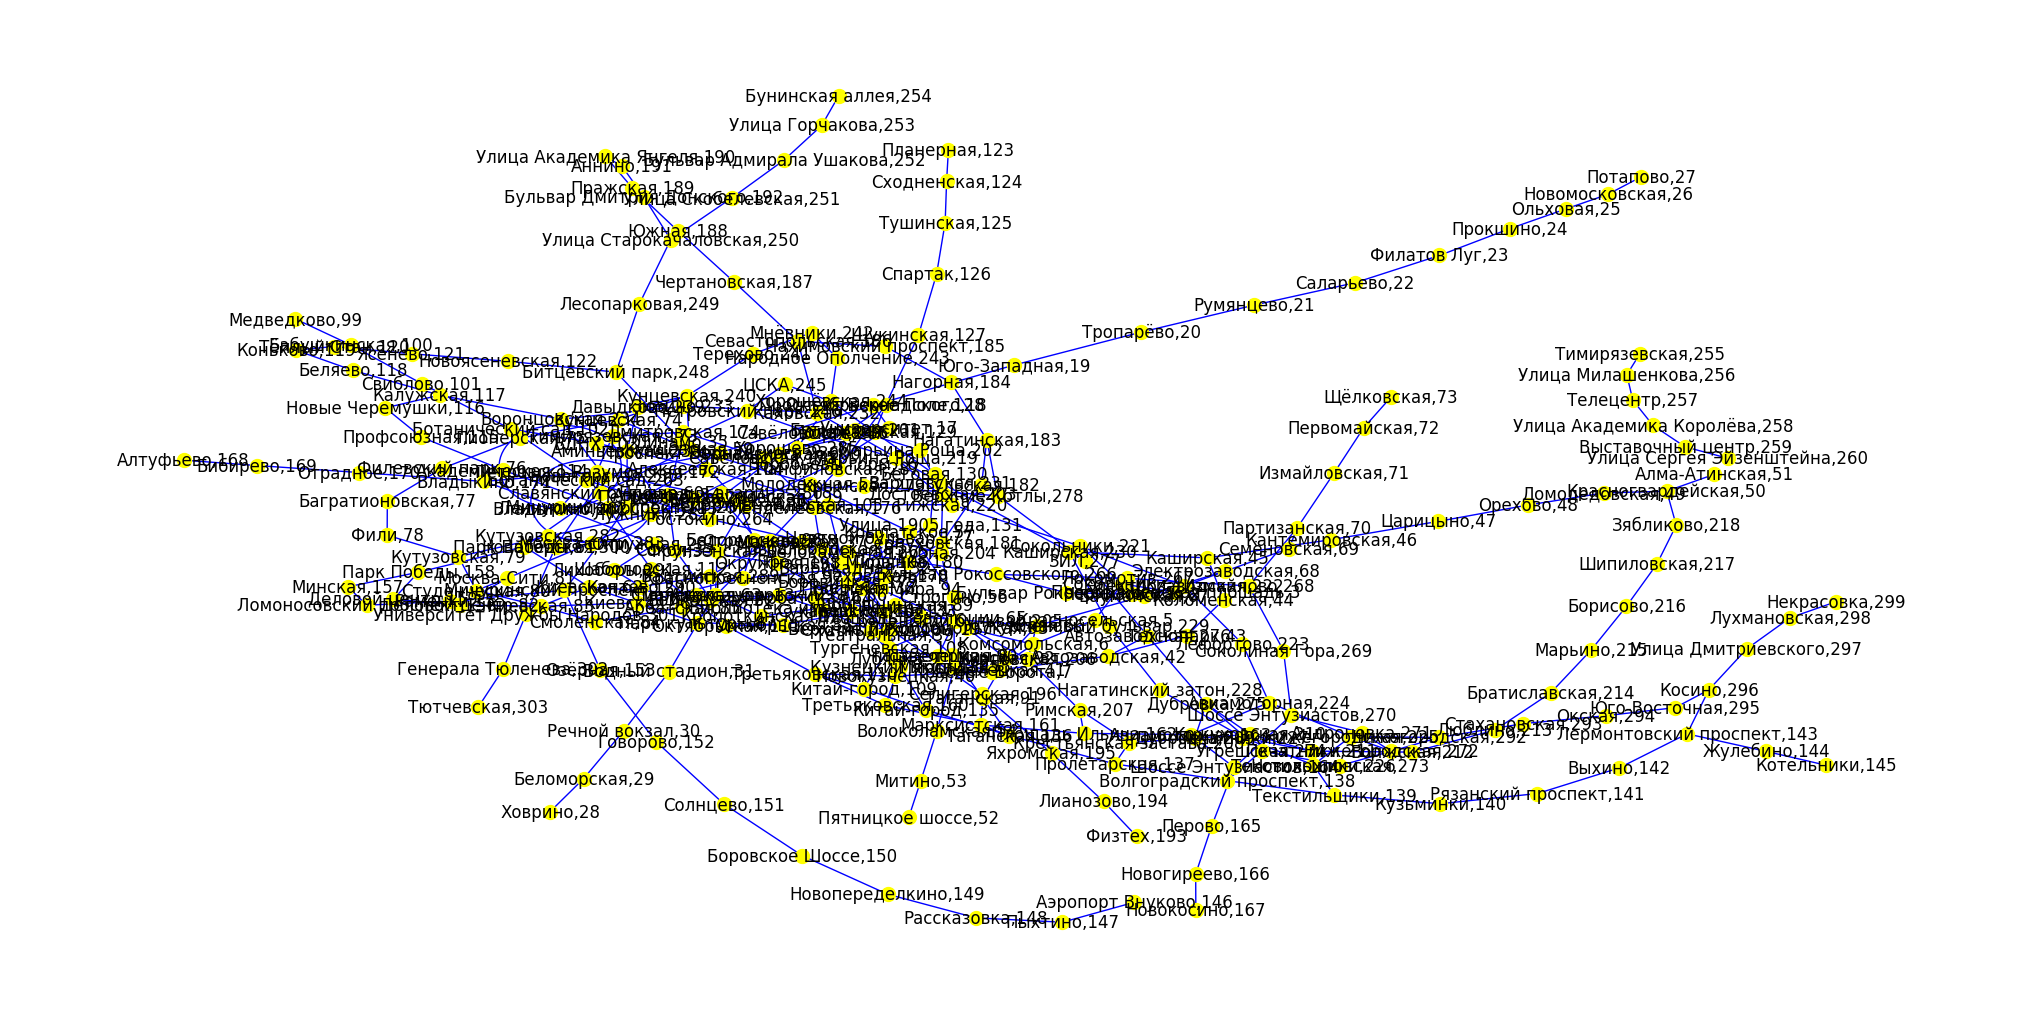

In [8]:
options = {
    'node_size': 100,
    'node_color':'yellow',
    'edge_color':'blue',
    'width':1,
    'font_weight':'normal'
}

fig = plt.figure(1, figsize=(20,10))
#pos = nx.circular_layout(G)
#pos = nx.random_layout(G)
#nx.draw(G, pos, with_labels=True, **options)
nx.draw(G, with_labels=True, **options)
#nx.draw_spring(G, with_labels=True, **options)

## PageRank: Top5 станций

In [9]:
# Выведем Top10, чтобы были нагляднее отличия Top5

N = 10
station_rank = nx.pagerank(G)

# сортируем
station_rank = sorted(station_rank.items(), key=lambda item: item[1], reverse=True)

print(f"Top {N} stations:")
for i, (n,r) in enumerate(station_rank[:N]):
    blanks = 28 -(len(n)+len(str(i+1)))
    print(f"{i+1}: {n} {' '*blanks} {r}")


Top 10 stations:
1: Киевская,83                  0.0051495161451000655
2: Войковская,32                0.0049235582229606644
3: Кунцевская,240               0.004908265474521621
4: Кунцевская,59                0.00489002698597442
5: Красногвардейская,50         0.004824977720234007
6: Владыкино,262                0.004785653937952209
7: Динамо,35                    0.004690132474816813
8: Боровицкая,179               0.004678529002442678
9: Библиотека имени Ленина,11   0.00464486147044838
10: Арбатская,64                0.004602261141909263


In [10]:
# смотрим в датасете
ms[ms['Station_index'].isin([83,32,240,59,50])]

,Station_index,English_name,Line,Russian_name,Depth,Line_Neighbors,Transfers,Opened_Date,Lat,Lon,Station_Type
31,32,Voykovskaya,2,Войковская,-7.0,31 33,288 289,1964-12-31,55.8190,37.4980,column triple-span
49,50,Krasnogvardeyskaya,2,Красногвардейская,-9.0,49 51,218,1985-09-07,55.6137,37.7444,single-vault shallow
58,59,Kuntsevskaya,3,Кунцевская,0.0,58 60,74 240,2008-01-07,55.7307,37.4459,surface open
82,83,Kiyevskaya,4,Киевская,-8.7,82 80 84,62 98,1937-03-20,55.7436,37.5655,column triple-vault
239,240,Kuntsevskaya,11,Кунцевская,-31.0,239 241,59 74,2021-12-07,55.7304,37.4457,column triple-span


В-общем, результат похож на правду:

* Киевская - с ней понятно - пересечение 3-х линий метро
* Войковская - пересечение линии метро и MЦК, причем с Войковской переход сразу на 2 станции МЦК (Стрешнево и Балтийская). Ранк большой из-за эффекта 'туннелирования', аналогично Красногвардейской.
* Кунцевская - пересечение 3-х линий метро и линии МЦД
* Красногвардейская - находится на пересечении двух длинных линий метро, причем Красногвардейская конечная станция обоих линий. Поэтому из-за эффекта 'туннелирования' ранк у Красногвардейской больше чем у центральных станций (Боровицкая, Библиотека им.Ленина, и т.д.).

Источник: https://mosmetro.ru/metro-map

# SimRank

In [11]:
station_simrank = nx.simrank_similarity(G)

In [12]:
# Посмотрим на кого больше похожа Красногвардейская
sorted(station_simrank['Красногвардейская,50'].items(), key=lambda item: item[1], reverse=True)[:3]

[('Красногвардейская,50', 1.0),
 ('Шипиловская,217', 0.4868537466446043),
 ('Орехово,48', 0.4784302523786244)]

In [13]:
# На кого похожи станции из PageRank 5

top5 = ["Киевская,83", "Войковская,32", "Кунцевская,240", "Кунцевская,59", "Красногвардейская,50"]
N = 3
indent = 4*" "

for s in top5:
    print(f"{s} похожа на:")
    sims = sorted(station_simrank[s].items(), key=lambda item: item[1], reverse=True)
    for i, (n,r) in enumerate(sims[1:N+1]):
        blanks = 28 -(len(n)+len(str(i+1)))
        print(f"{indent}{i+1}: {n} {' '*blanks} {r}")



Киевская,83 похожа на:
    1: Москва-Сити,81               0.2807658718908269
    2: Деловой центр,159            0.25993998719664707
    3: Арбатская,85                 0.228398904867025
Войковская,32 похожа на:
    1: Речной вокзал,30             0.3378108362266219
    2: Коптево,290                  0.28326219526030055
    3: Аэропорт,34                  0.27513512909793514
Кунцевская,240 похожа на:
    1: Мнёвники,242                 0.2942123346252974
    2: Пионерская,75                0.2811914676607227
    3: Аминьевская,238              0.2799862373026868
Кунцевская,59 похожа на:
    1: Крылатское,57                0.30713121375234165
    2: Пионерская,75                0.2797309808608782
    3: Терехово,241                 0.26435708248645867
Красногвардейская,50 похожа на:
    1: Шипиловская,217              0.4868537466446043
    2: Орехово,48                   0.4784302523786244
    3: Марьино,215                  0.24142089774591072


# Случайные разреженные графы


Матрица:
[[0 0 0 0]
 [0 0 0 1]
 [1 1 1 1]
 [0 0 1 0]]
Как соединения вершин:
Узел 0 ->  
Узел 1 ->  3 
Узел 2 ->  0 1 2 3 
Узел 3 ->  2 
Как граф:


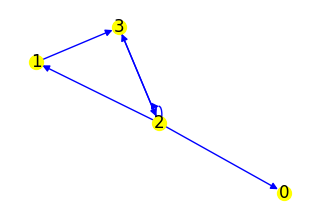

In [16]:
def create_sparse_matrix(size, density):
    def values(size): return np.random.randint(0,2, size=size)
    return sparse_random(size, size, density=density, format='csr',
                         dtype=np.int32,
                         data_rvs = values)

# проверяем
matrix = create_sparse_matrix(size=4, density=0.5).todense()
print("Матрица:")
print(matrix)

# то же самое в терминах вершин
print("Как соединения вершин:")
row_len = matrix.shape[1]
for vertex, row in enumerate(matrix):
    print(f"Узел {vertex} -> ", end=" ")
    for i in range(row_len):
        if(row[0,i] != 0):
            print(i, end=" ")
    print()

# Как граф
print("Как граф:")
G = nx.from_numpy_array(matrix, parallel_edges=False, create_using=nx.DiGraph)
fig = plt.figure(1, figsize=(3,2))
nx.draw(G, with_labels=True, **options)

#
# Comment: Можно было сразу сгенерировать граф: nx.gnp_random_graph(n=5, p=0.1, directed=True)
#

## PageRank обычный vs PageRank CSR

In [68]:
# Генерируем случайный разреженный граф
size = 1024 * 10
density = 0.1   # 10% not-null elements

sparce_matrix = create_sparse_matrix(size=size, density=density)
dense_matrix = sparce_matrix.todense()

G = nx.from_numpy_array(dense_matrix, parallel_edges=False, create_using=nx.DiGraph)

In [69]:
# PageRank обычный
%%time
rank = nx.pagerank(G)
len(rank)

CPU times: user 5.88 s, sys: 876 ms, total: 6.76 s
Wall time: 6.78 s


10240

In [70]:
%%time
fast_rank = fast_pagerank.pagerank_power(sparce_matrix)
len(fast_rank)

CPU times: user 281 ms, sys: 63.6 ms, total: 345 ms
Wall time: 302 ms


10240

In [71]:
# Top 10 простого PageRank
N = 10
sorted(list(rank.items()), key=lambda i:i[1], reverse=True)[:N]

[(4287, 0.00011446266691947797),
 (4813, 0.00011087108320485788),
 (7431, 0.00011072589980338387),
 (4760, 0.00011010274213117735),
 (9088, 0.00010976749846251707),
 (3723, 0.00010968249298609307),
 (3249, 0.00010961891876972304),
 (5638, 0.00010956439616479881),
 (7459, 0.00010951489928846175),
 (1768, 0.00010902196529813412)]

In [72]:
# Top 10 PageRank with CSR
indices=np.argsort(fast_rank)#[-N:]
[i for i in zip(indices, fast_rank)][-N:][::-1]

[(np.int64(4287), np.float64(9.852472016261741e-05)),
 (np.int64(4813), np.float64(0.00010348766246620524)),
 (np.int64(7431), np.float64(9.639279566846801e-05)),
 (np.int64(4760), np.float64(0.0001001318457484228)),
 (np.int64(9088), np.float64(0.00010073982507446517)),
 (np.int64(3723), np.float64(9.423456520755668e-05)),
 (np.int64(3249), np.float64(9.312309928738339e-05)),
 (np.int64(5638), np.float64(9.817321473304349e-05)),
 (np.int64(7459), np.float64(0.00010053206205762914)),
 (np.int64(1768), np.float64(8.945130397072411e-05))]

Абсолютные значения простого PageRank и PageRank CSR отличаются. Но ранжировку узлов оба алгоритма дали одинаковую.

PageRank SCR в 20 раз быстрее на матрице 1024 x 1024. Выигрыш PageRank CSR тем больше, чем больше размерность матрицы.